**Final Project**

Prediction system to predict sentiment score from post comment on social media.


In [ ]:
import pandas as pd
import numpy as np
import kagglehub
from kagglehub import KaggleDatasetAdapter

!pip install nltk
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
from scipy.sparse import hstack
import re

nltk.download('wordnet')
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('punkt_tab')

import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import skew
from sklearn.preprocessing import LabelEncoder, OrdinalEncoder, StandardScaler, PolynomialFeatures
from sklearn.metrics import make_scorer
from sklearn.model_selection import cross_validate, cross_val_score, cross_val_predict
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor


[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


# EDA

In [ ]:
# Set the path to the file you'd like to load
file_path = "Social Media Engagement Dataset.csv"

# Load the latest version
df = kagglehub.load_dataset(
  KaggleDatasetAdapter.PANDAS,
  "subashmaster0411/social-media-engagement-dataset",
  file_path,
  # Provide any additional arguments like
  # sql_query or pandas_kwargs. See the
  # documenation for more information:
  # https://github.com/Kaggle/kagglehub/blob/main/README.md#kaggledatasetadapterpandas
)

pd.set_option('display.max_columns', None)

Using Colab cache for faster access to the 'social-media-engagement-dataset' dataset.


In [ ]:
df.head()

,post_id,timestamp,day_of_week,platform,user_id,location,language,text_content,hashtags,mentions,keywords,topic_category,sentiment_score,sentiment_label,emotion_type,toxicity_score,likes_count,shares_count,comments_count,impressions,engagement_rate,brand_name,product_name,campaign_name,campaign_phase,user_past_sentiment_avg,user_engagement_growth,buzz_change_rate
0,kcqbs6hxybia,2024-12-09 11:26:15,Monday,Instagram,user_52nwb0a6,"Melbourne, Australia",pt,Just tried the Chromebook from Google. Best pu...,#Food,NaN,"price, unique, traditional, efficient",Pricing,0.9826,Positive,Confused,0.0376,1264,1704,701,18991,0.19319,Google,Chromebook,BlackFriday,Launch,0.0953,-0.3672,19.1
1,vkmervg4ioos,2024-07-28 19:59:26,Sunday,Twitter,user_ucryct98,"Tokyo, Japan",ru,Just saw an ad for Microsoft Surface Laptop du...,"#MustHave, #Food","@CustomerService, @BrandCEO","delivery, slow",Delivery,-0.3793,Negative,Angry,0.9715,522,1803,359,52764,0.05086,Microsoft,Surface Laptop,PowerRelease,Post-Launch,0.1369,-0.4510,-42.6
2,memhx4o1x6yu,2024-11-23 14:00:12,Saturday,Reddit,user_7rrev126,"Beijing, China",ru,What's your opinion about Nike's Epic React? ...,"#Promo, #Food, #Trending",NaN,"reliable, budget, durable, experience",Product,-0.3596,Negative,Confused,0.5124,2689,705,643,8887,0.45425,Nike,Epic React,BlackFriday,Post-Launch,0.2855,-0.4112,17.4
3,bhyo6piijqt9,2024-09-16 04:35:25,Monday,YouTube,user_4mxuq0ax,"Lagos, Nigeria",en,Bummed out with my new Diet Pepsi from Pepsi! ...,"#Reviews, #Sustainable","@StyleGuide, @BrandSupport","improved, competitive, luxury, fast",Delivery,-0.7282,Negative,Sad,0.4002,1827,262,743,6696,0.42293,Pepsi,Diet Pepsi,LaunchWave,Launch,-0.2094,-0.0167,-5.5
4,c9dkiomowakt,2024-09-05 21:03:01,Thursday,Twitter,user_l1vpox2k,"Berlin, Germany",hi,Just tried the Corolla from Toyota. Absolutely...,"#Health, #Travel","@BrandSupport, @InfluencerName","innovation, budget, helpful, luxury",Product,0.5460,Positive,Happy,0.0862,2005,1443,703,47315,0.08773,Toyota,Corolla,LocalTouchpoints,Launch,0.6867,0.0807,38.8


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12000 entries, 0 to 11999
Data columns (total 28 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   post_id                  12000 non-null  object 
 1   timestamp                12000 non-null  object 
 2   day_of_week              12000 non-null  object 
 3   platform                 12000 non-null  object 
 4   user_id                  12000 non-null  object 
 5   location                 12000 non-null  object 
 6   language                 12000 non-null  object 
 7   text_content             12000 non-null  object 
 8   hashtags                 12000 non-null  object 
 9   mentions                 8059 non-null   object 
 10  keywords                 12000 non-null  object 
 11  topic_category           12000 non-null  object 
 12  sentiment_score          12000 non-null  float64
 13  sentiment_label          12000 non-null  object 
 14  emotion_type          

In [ ]:
df.isnull().sum()

,0
post_id,0
timestamp,0
day_of_week,0
platform,0
user_id,0
location,0
language,0
text_content,0
hashtags,0
mentions,3941


In [ ]:
df.duplicated().sum()

np.int64(0)

In [ ]:
df.describe()

,sentiment_score,toxicity_score,likes_count,shares_count,comments_count,impressions,engagement_rate,user_past_sentiment_avg,user_engagement_growth,buzz_change_rate
count,12000.000000,12000.000000,12000.00000,12000.000000,12000.00000,12000.000000,12000.000000,12000.000000,12000.000000,12000.000000
mean,0.000553,0.503868,2490.72025,1007.167167,504.34575,49811.338500,0.278137,0.001472,0.000998,0.729692
std,0.583563,0.288198,1441.53253,575.072282,288.68416,28930.289451,1.149206,0.576627,0.289940,57.787219
min,-0.999800,0.000000,0.00000,0.000000,0.00000,130.000000,0.001880,-0.999600,-0.499900,-99.900000
25%,-0.503200,0.251400,1236.00000,510.000000,253.00000,24716.500000,0.049100,-0.495975,-0.248400,-48.700000
50%,-0.006200,0.505950,2496.00000,1018.000000,503.00000,49674.000000,0.080605,0.001950,0.002800,0.900000
75%,0.513525,0.756200,3723.25000,1501.000000,755.00000,74815.000000,0.163123,0.501725,0.250700,50.100000
max,0.999900,0.999900,5000.00000,2000.000000,1000.00000,99997.000000,32.211710,0.999400,0.499900,99.900000


## Data Visualization








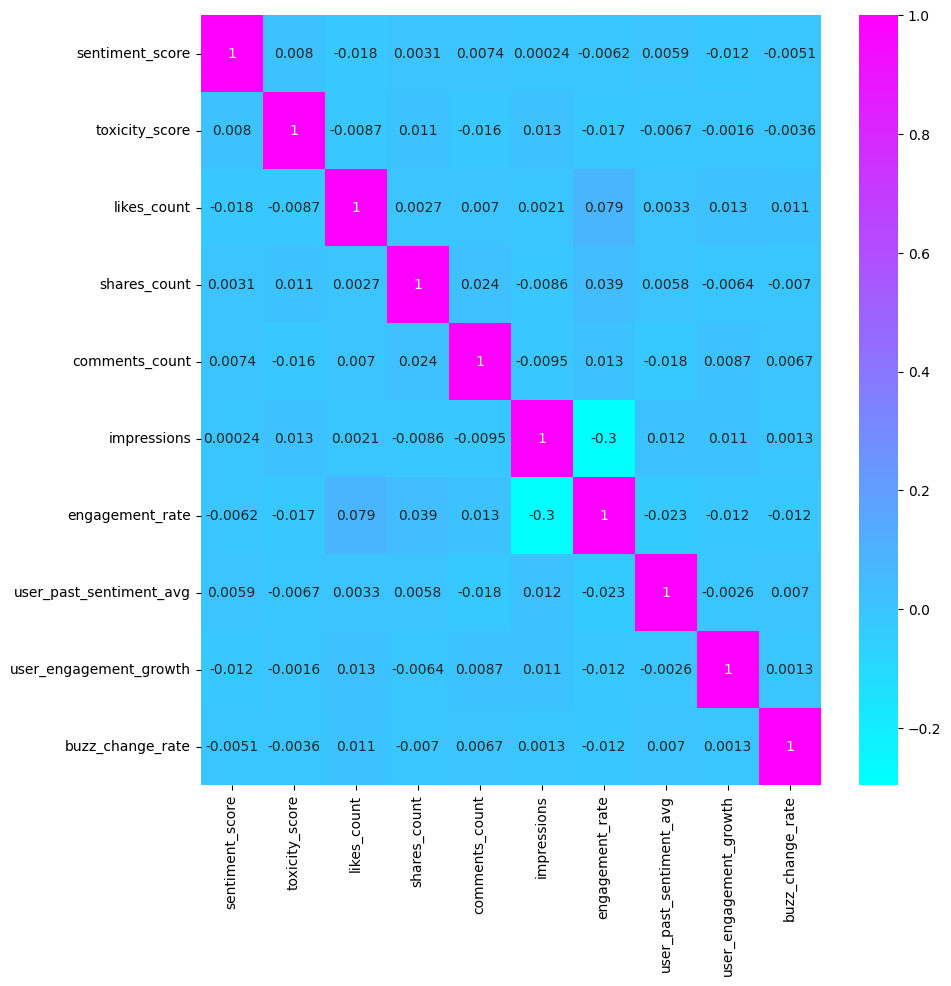

In [ ]:
f, ax = plt.subplots(figsize=(10, 10))
ax = sns.heatmap(df.select_dtypes(include=['float64', 'int64']).corr(), annot=True, cmap="cool")

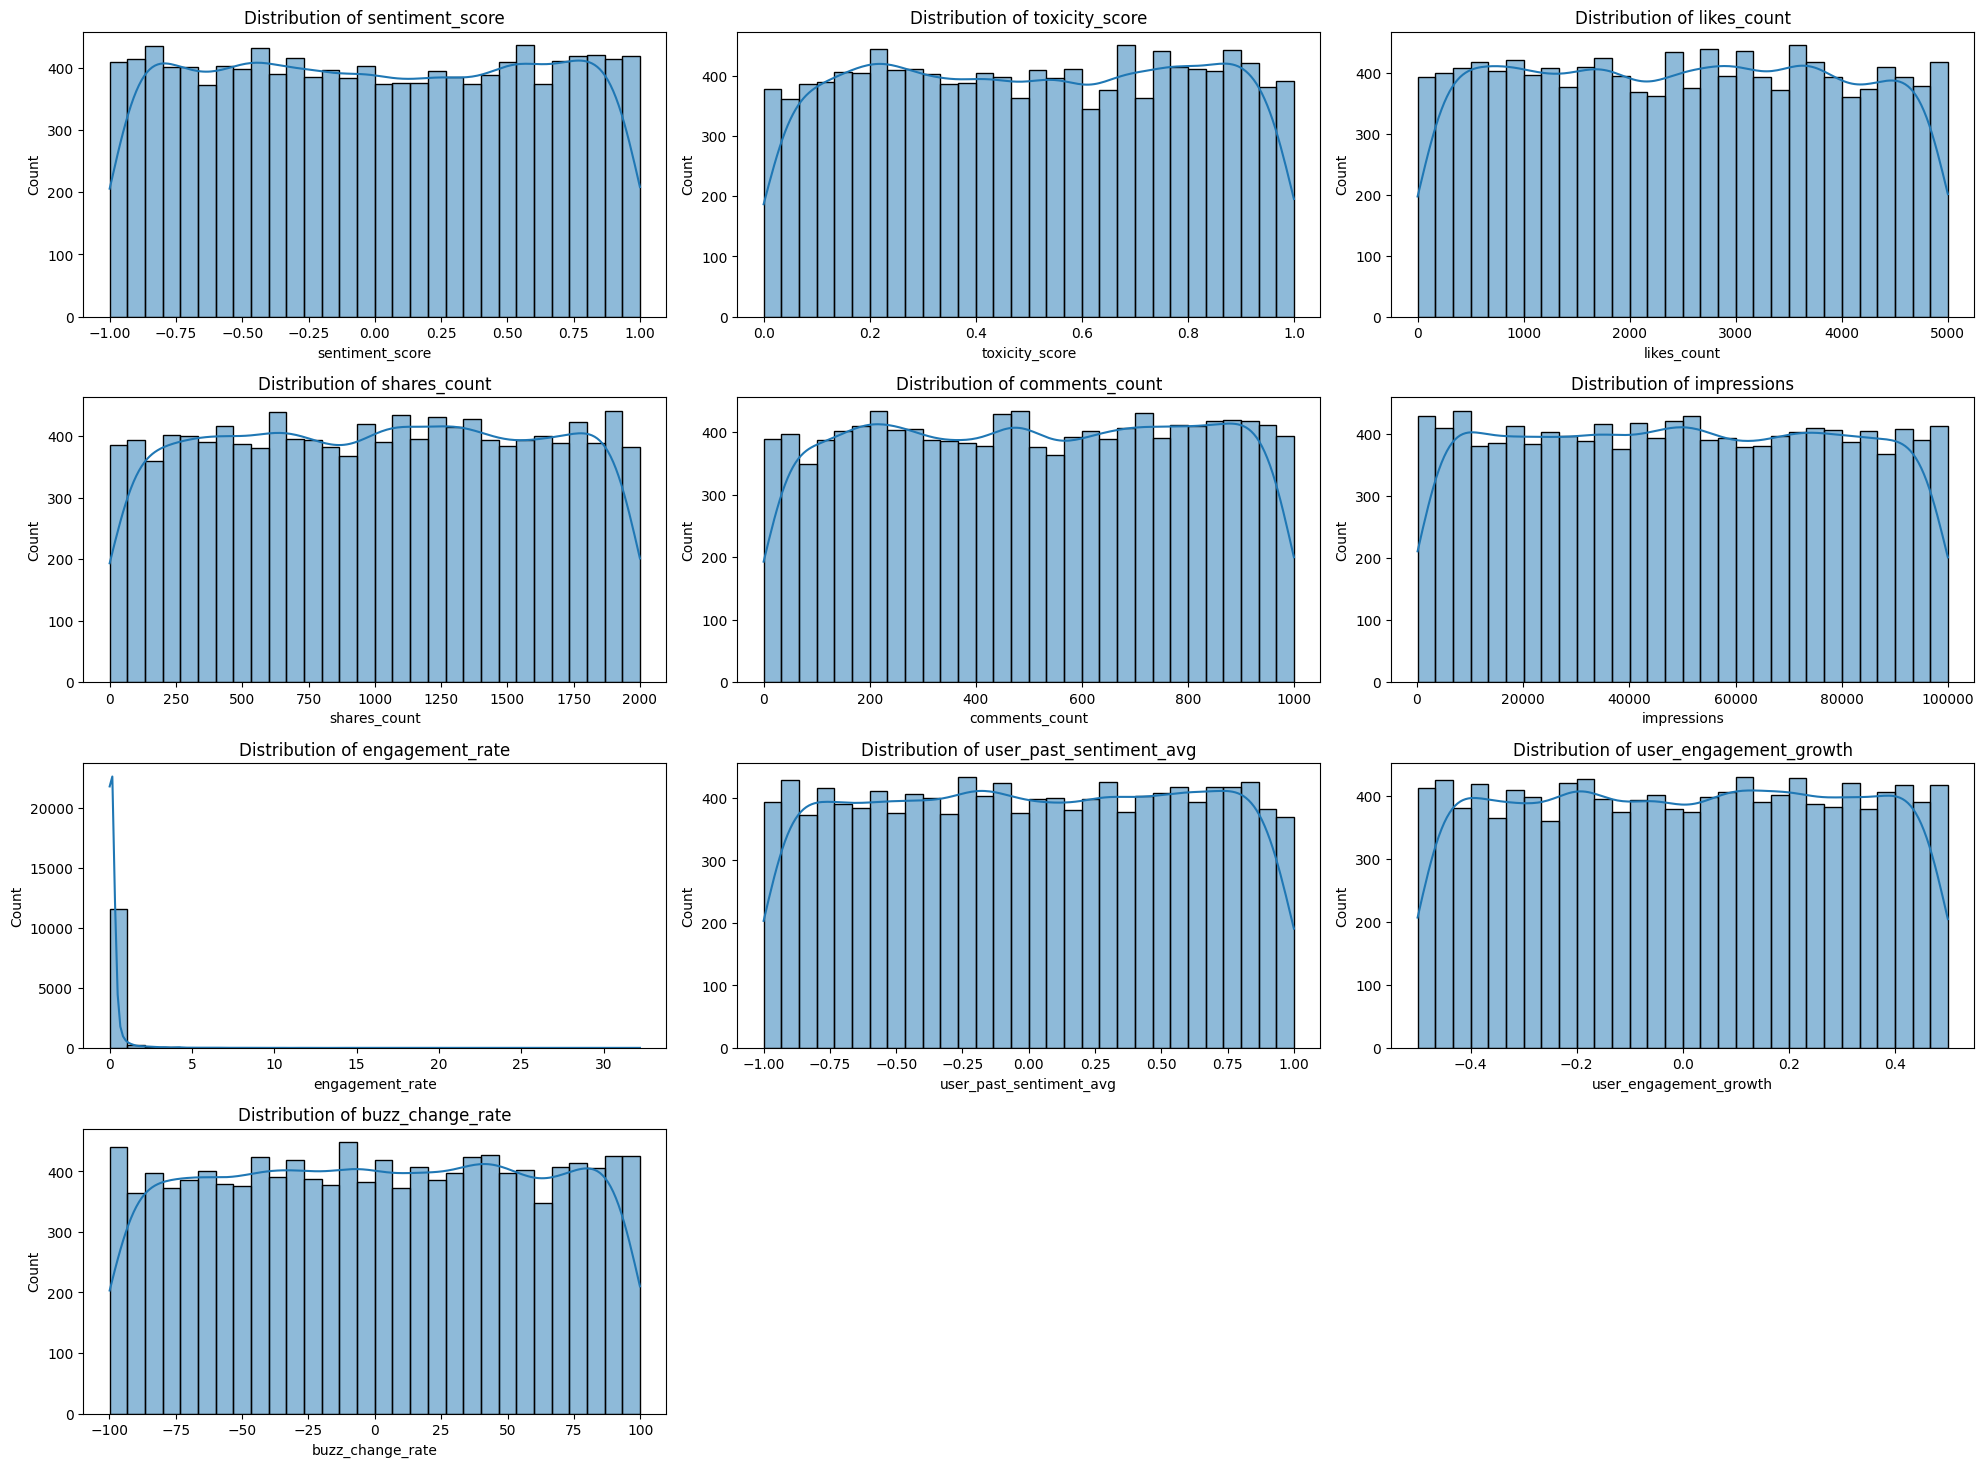

In [ ]:
# Select numeric columns
numeric_cols = df.select_dtypes(include=['int64', 'float64']).columns

# Plot distributions with KDE
plt.figure(figsize=(20, 18))

for i, col in enumerate(numeric_cols, 1):
    plt.subplot(5, 3, i)
    sns.histplot(df[col], kde=True, bins=30)
    plt.title(f"Distribution of {col}")

plt.tight_layout()
plt.show()

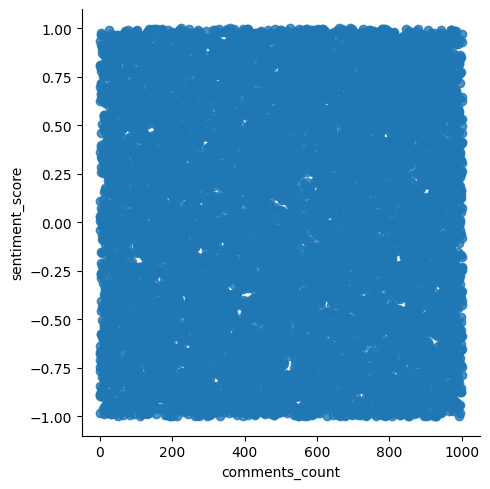

In [ ]:
ax = sns.lmplot(x='comments_count', y ='sentiment_score', data = df)

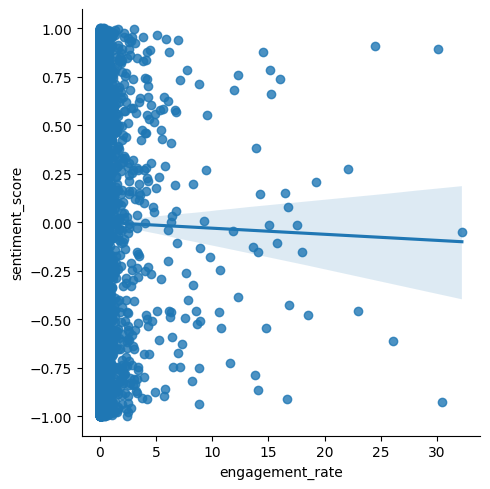

In [ ]:
ax = sns.lmplot(x='engagement_rate', y ='sentiment_score', data = df)

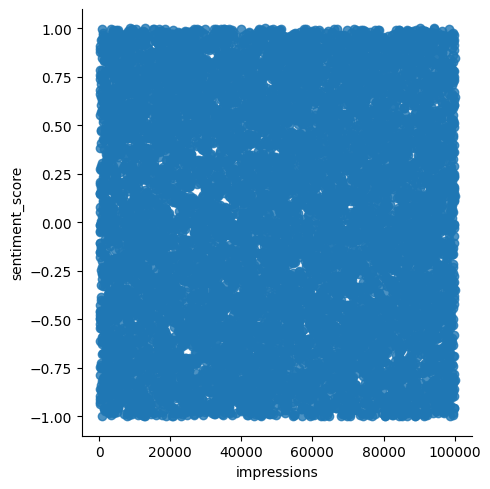

In [ ]:
ax = sns.lmplot(x='impressions', y ='sentiment_score', data = df)

In [ ]:
platformSentiment = df.groupby('platform')['sentiment_score'].mean().sort_values(ascending=True)
sentimentByCampaign = df.groupby('campaign_name')['sentiment_score'].mean().sort_values(ascending=True)
sentimentByLocation = df.groupby('location')['sentiment_score'].mean().sort_values(ascending=True)
sentimentByLanguage = df.groupby('language')['sentiment_score'].mean().sort_values(ascending=True)


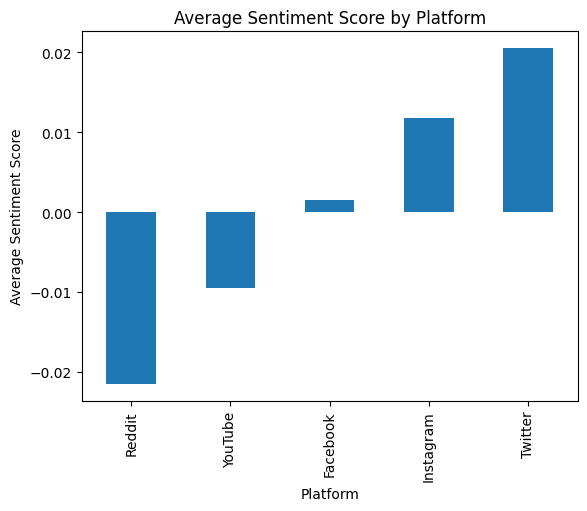

In [ ]:
platformSentiment.plot(kind='bar')
plt.title('Average Sentiment Score by Platform')
plt.xlabel('Platform')
plt.ylabel('Average Sentiment Score')
plt.show()

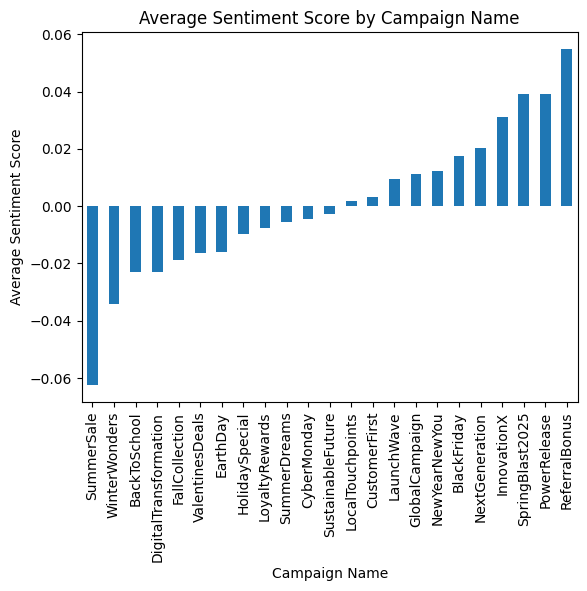

In [ ]:
sentimentByCampaign.plot(kind='bar')
plt.title('Average Sentiment Score by Campaign Name')
plt.xlabel('Campaign Name')
plt.ylabel('Average Sentiment Score')
plt.show()

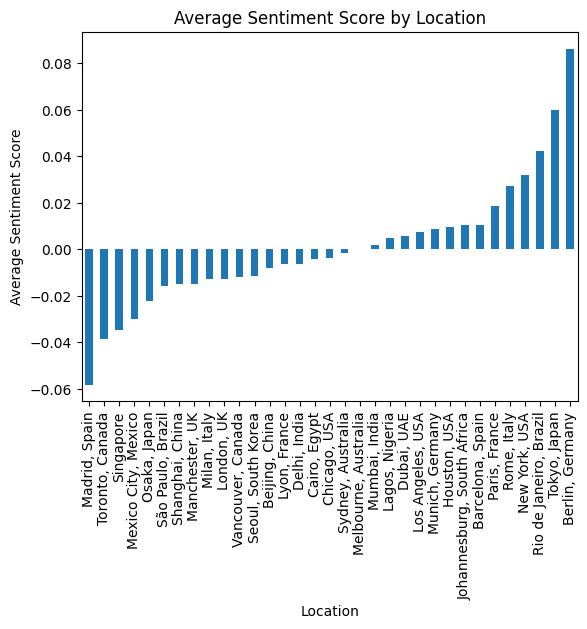

In [ ]:
sentimentByLocation.plot(kind='bar')
plt.title('Average Sentiment Score by Location')
plt.xlabel('Location')
plt.ylabel('Average Sentiment Score')
plt.show()

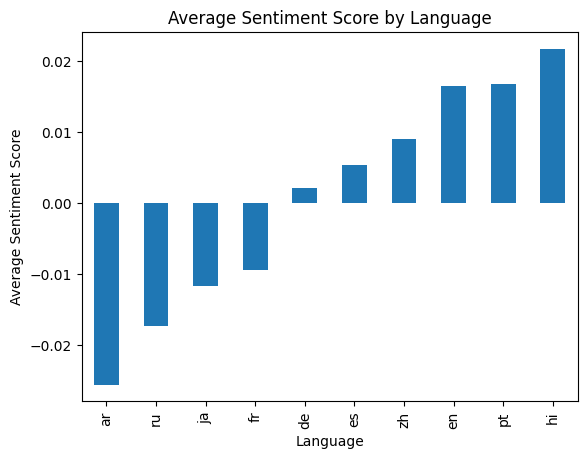

In [ ]:
sentimentByLanguage.plot(kind='bar')
plt.title('Average Sentiment Score by Language')
plt.xlabel('Language')
plt.ylabel('Average Sentiment Score')
plt.show()

## Data Cleaning

Timestamp Cleaning

In [ ]:
df["timestamp"] = pd.to_datetime(df["timestamp"])

In [ ]:
# Convert Timestamp to day, hour, month and year
df["year"] = df["timestamp"].dt.year
df["month"] = df["timestamp"].dt.month
df["day"] = df["timestamp"].dt.day
df["hour"] = df["timestamp"].dt.hour

In [ ]:
df = df.drop(columns=["timestamp"], axis=1)

Deleting Anomalies on Engagement Rate

In [ ]:
dfanomalies = df.copy()["engagement_rate"] > 10
dfanomalies = dfanomalies == True
total_true_anomalies = dfanomalies.sum()
print(f"Total number of anomalies (engagement rate > 10): {total_true_anomalies}")

Total number of anomalies (engagement rate > 10): 36


In [ ]:
df = df.drop(df[dfanomalies].index)

Filling Null Values

In [ ]:
df["mentions"] = df["mentions"].fillna("None")

## Proccessing Text Data

In [ ]:
# Word Proccessing Function
def word_preproccessing (col):
  regex_pattern = r'[^\w\s]|[\d]'

  stop_words = set(stopwords.words('english'))
  lemmatizer = WordNetLemmatizer()
  ps = PorterStemmer()

  for col in col:
    df[col] = df[col].apply(lambda x: x.lower())
    if col != 'mentions':
      df[col] = df[col].apply(lambda x: re.sub(r'@\w+', '', x))
    if col != 'hashtags':
      df[col] = df[col].apply(lambda x: re.sub(r'#\w+', '', x))
      df[col] = df[col].apply(lambda x: re.sub(regex_pattern, ' ', x))
    else:
      df[col] = df[col].apply(lambda x: re.sub(r'#', '', x))

    df[col] = df[col].apply(lambda x: re.sub(r'\s+', ' ', x).strip())

    # Tokenization
    df[col] = df[col].apply(lambda x: ' '.join([word for word in word_tokenize(x) if word not in (stop_words)]))

    # Lemmatization
    df[col] = df[col].apply(lambda x: ' '.join([lemmatizer.lemmatize(word, 'v') for word in x.split()]))

    # Stemming
    df[col] = df[col].apply(lambda x: ' '.join([ps.stem(word) for word in x.split()]))

In [ ]:
word_columns = ['text_content', 'mentions', 'hashtags']
word_preproccessing(word_columns)
df.head()

,post_id,day_of_week,platform,user_id,location,language,text_content,hashtags,mentions,keywords,topic_category,sentiment_score,sentiment_label,emotion_type,toxicity_score,likes_count,shares_count,comments_count,impressions,engagement_rate,brand_name,product_name,campaign_name,campaign_phase,user_past_sentiment_avg,user_engagement_growth,buzz_change_rate,year,month,day,hour
0,kcqbs6hxybia,Monday,Instagram,user_52nwb0a6,"Melbourne, Australia",pt,tri chromebook googl best purchas ever realli ...,food,none,"price, unique, traditional, efficient",Pricing,0.9826,Positive,Confused,0.0376,1264,1704,701,18991,0.19319,Google,Chromebook,BlackFriday,Launch,0.0953,-0.3672,19.1,2024,12,9,11
1,vkmervg4ioos,Sunday,Twitter,user_ucryct98,"Tokyo, Japan",ru,saw ad microsoft surfac laptop springblast wor...,"musthav , food",customerservic brandceo,"delivery, slow",Delivery,-0.3793,Negative,Angry,0.9715,522,1803,359,52764,0.05086,Microsoft,Surface Laptop,PowerRelease,Post-Launch,0.1369,-0.4510,-42.6,2024,7,28,19
2,memhx4o1x6yu,Saturday,Reddit,user_7rrev126,"Beijing, China",ru,opinion nike epic react realli interest hear t...,"promo , food , trend",none,"reliable, budget, durable, experience",Product,-0.3596,Negative,Confused,0.5124,2689,705,643,8887,0.45425,Nike,Epic React,BlackFriday,Post-Launch,0.2855,-0.4112,17.4,2024,11,23,14
3,bhyo6piijqt9,Monday,YouTube,user_4mxuq0ax,"Lagos, Nigeria",en,bum new diet pepsi pepsi disappoint qualiti,"review , sustain",styleguid brandsupport,"improved, competitive, luxury, fast",Delivery,-0.7282,Negative,Sad,0.4002,1827,262,743,6696,0.42293,Pepsi,Diet Pepsi,LaunchWave,Launch,-0.2094,-0.0167,-5.5,2024,9,16,4
4,c9dkiomowakt,Thursday,Twitter,user_l1vpox2k,"Berlin, Germany",hi,tri corolla toyota absolut love realli interes...,"health , travel",brandsupport influencernam,"innovation, budget, helpful, luxury",Product,0.5460,Positive,Happy,0.0862,2005,1443,703,47315,0.08773,Toyota,Corolla,LocalTouchpoints,Launch,0.6867,0.0807,38.8,2024,9,5,21


TFIDF Application

In [ ]:
# --- Step 1: Initialize TF-IDF Vectorizer
tfidf = TfidfVectorizer(
    max_features=1000,   # keep only top 1000 words
    stop_words='english' # remove common stopwords
)

# --- Step 2: Fit + Transform text
tfidf_text = TfidfVectorizer(max_features=3000).fit_transform(df["text_content"])
tfidf_mentions = TfidfVectorizer(max_features=1000).fit_transform(df["mentions"])
tfidf_hashtags = TfidfVectorizer(max_features=1000).fit_transform(df["hashtags"])

X_tfidf = hstack([tfidf_text, tfidf_mentions, tfidf_hashtags])

# Build feature names
tfidf_feature_names = (
    [f"text_{w}" for w in TfidfVectorizer(max_features=3000).fit(df["text_content"]).get_feature_names_out()] +
    [f"mentions_{w}" for w in TfidfVectorizer(max_features=1000).fit(df["mentions"]).get_feature_names_out()] +
    [f"hashtag_{w}" for w in TfidfVectorizer(max_features=1000).fit(df["hashtags"]).get_feature_names_out()]
)

# Convert sparse matrix to DataFrame
df_tfidf = pd.DataFrame.sparse.from_spmatrix(X_tfidf, columns=tfidf_feature_names)

df_tfidf.head()


,text_absolut,text_accept,text_ad,text_adida,text_advic,text_air,text_airpod,text_amaz,text_amazon,text_anyon,text_appl,text_asap,text_attend,text_backtoschool,text_bad,text_band,text_batteri,text_believ,text_best,text_blackfriday,text_bud,text_bug,text_bum,text_camera,text_camri,text_cherri,text_chromebook,text_coca,text_coke,text_cola,text_come,text_compar,text_competit,text_confus,text_connect,text_contain,text_control,text_corolla,text_could,text_crystal,text_curiou,text_custom,text_customerfirst,text_cybermonday,text_day,text_decent,text_delay,text_delight,text_deliveri,text_diet,text_digitaltransform,text_disappoint,text_dot,text_dri,text_duo,text_earthday,text_echo,text_eero,text_elit,text_els,text_epic,text_event,text_ever,text_everi,text_exceed,text_excel,text_excit,text_expect,text_experi,text_explain,text_fallcollect,text_fanta,text_fantast,text_feed,text_feedback,text_feel,text_fire,text_fit,text_fix,text_flyknit,text_fold,text_forc,text_frustrat,text_galaxi,text_gazel,text_get,text_globalcampaign,text_go,text_googl,text_halo,text_happi,text_hear,text_highland,text_highli,text_holidayspeci,text_hub,text_imac,text_impress,text_innovationx,text_interest,text_ipad,text_iphon,text_issu,text_job,text_jordan,text_kindl,text_know,text_laptop,text_launchwav,text_let,text_lime,text_localtouchpoint,text_love,text_loyaltyreward,text_mac,text_macbook,text_max,text_microsoft,text_mini,text_mix,text_money,text_month,text_neo,text_nest,text_new,text_newyearnewy,text_next,text_nextgener,text_nike,text_nmd,text_okay,text_one,text_opinion,text_outstand,text_overpric,text_pegasu,text_penni,text_pepsi,text_pixel,text_powerreleas,text_predat,text_priu,text_pro,text_problem,text_purchas,text_qled,text_qualiti,text_rav,text_react,text_realli,text_recommend,text_referralbonu,text_report,text_return,text_review,text_ring,text_sad,text_samba,text_samsung,text_saw,text_see,text_seri,text_servic,text_sienna,text_six,text_smith,text_softwar,text_someon,text_springblast,text_sprite,text_stan,text_standard,text_subpar,text_sugar,text_summerdream,text_summersal,text_super,text_superstar,text_sure,text_surfac,text_sustainablefutur,text_tab,text_tablet,text_tacoma,text_thermostat,text_think,text_thought,text_three,text_thrill,text_tip,text_toyota,text_tri,text_tundra,text_tv,text_two,text_typic,text_ultraboost,text_unbox,text_underwhelm,text_upgrad,text_valentinesd,text_vanilla,text_vision,text_wait,text_watch,text_week,text_wifi,text_wild,text_winterwond,text_worth,text_would,text_xbox,text_year,text_yeezi,text_yesterday,text_zero,text_zoom,mentions_brandceo,mentions_brandsupport,mentions_celebritynam,mentions_competitorbrand,mentions_customerservic,mentions_industryexpert,mentions_influencernam,mentions_marketingteam,mentions_newsoutlet,mentions_none,mentions_productteam,mentions_retailsupport,mentions_reviewsit,mentions_styleguid,mentions_techhelp,mentions_trendsett,hashtag_afford,hashtag_beauti,hashtag_bestvalu,hashtag_customerservic,hashtag_deal,hashtag_discount,hashtag_eco,hashtag_exclus,hashtag_fashion,hashtag_fit,hashtag_food,hashtag_health,hashtag_innov,hashtag_lifestyl,hashtag_limit,hashtag_musthav,hashtag_newreleas,hashtag_premium,hashtag_productlaunch,hashtag_promo,hashtag_qualiti,hashtag_review,hashtag_sale,hashtag_specialoff,hashtag_sustain,hashtag_tech,hashtag_travel,hashtag_trend,hashtag_trendalert
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.340011,0,0,0,0,0,0,0,0.494088,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.340011,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.292537,0,0,0.242602,0,0,0,0,0,0,0,0.242602,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.340011,0,0,0,0,0.242602,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.242602,0,0,0,0,0.296739,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0.292881,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0

In [ ]:
df_tfidf_temp = df_tfidf.copy()
df_tfidf_temp["sentiment_score"] = df["sentiment_score"].values
# Compute correlation (only with sentiment_score)
corr_with_engagement = df_tfidf_temp.corr()["sentiment_score"].sort_values(ascending=False)

# Show top 15 correlations
corr_with_engagement.head(15)

,sentiment_score
sentiment_score,1.000000
text_everi,0.279318
text_penni,0.279318
text_absolut,0.273017
text_exceed,0.272826
text_highli,0.266330
text_purchas,0.261782
text_best,0.261782
text_ever,0.261782
text_expect,0.226302


In [ ]:
# Drop Text Columns
df = df.drop(columns=['text_content', 'mentions', 'hashtags', 'keywords'], axis=1)


In [ ]:
df = pd.merge(df, df_tfidf, left_index=True, right_index=True)
df.head()

,post_id,day_of_week,platform,user_id,location,language,topic_category,sentiment_score,sentiment_label,emotion_type,toxicity_score,likes_count,shares_count,comments_count,impressions,engagement_rate,brand_name,product_name,campaign_name,campaign_phase,user_past_sentiment_avg,user_engagement_growth,buzz_change_rate,year,month,day,hour,text_absolut,text_accept,text_ad,text_adida,text_advic,text_air,text_airpod,text_amaz,text_amazon,text_anyon,text_appl,text_asap,text_attend,text_backtoschool,text_bad,text_band,text_batteri,text_believ,text_best,text_blackfriday,text_bud,text_bug,text_bum,text_camera,text_camri,text_cherri,text_chromebook,text_coca,text_coke,text_cola,text_come,text_compar,text_competit,text_confus,text_connect,text_contain,text_control,text_corolla,text_could,text_crystal,text_curiou,text_custom,text_customerfirst,text_cybermonday,text_day,text_decent,text_delay,text_delight,text_deliveri,text_diet,text_digitaltransform,text_disappoint,text_dot,text_dri,text_duo,text_earthday,text_echo,text_eero,text_elit,text_els,text_epic,text_event,text_ever,text_everi,text_exceed,text_excel,text_excit,text_expect,text_experi,text_explain,text_fallcollect,text_fanta,text_fantast,text_feed,text_feedback,text_feel,text_fire,text_fit,text_fix,text_flyknit,text_fold,text_forc,text_frustrat,text_galaxi,text_gazel,text_get,text_globalcampaign,text_go,text_googl,text_halo,text_happi,text_hear,text_highland,text_highli,text_holidayspeci,text_hub,text_imac,text_impress,text_innovationx,text_interest,text_ipad,text_iphon,text_issu,text_job,text_jordan,text_kindl,text_know,text_laptop,text_launchwav,text_let,text_lime,text_localtouchpoint,text_love,text_loyaltyreward,text_mac,text_macbook,text_max,text_microsoft,text_mini,text_mix,text_money,text_month,text_neo,text_nest,text_new,text_newyearnewy,text_next,text_nextgener,text_nike,text_nmd,text_okay,text_one,text_opinion,text_outstand,text_overpric,text_pegasu,text_penni,text_pepsi,text_pixel,text_powerreleas,text_predat,text_priu,text_pro,text_problem,text_purchas,text_qled,text_qualiti,text_rav,text_react,text_realli,text_recommend,text_referralbonu,text_report,text_return,text_review,text_ring,text_sad,text_samba,text_samsung,text_saw,text_see,text_seri,text_servic,text_sienna,text_six,text_smith,text_softwar,text_someon,text_springblast,text_sprite,text_stan,text_standard,text_subpar,text_sugar,text_summerdream,text_summersal,text_super,text_superstar,text_sure,text_surfac,text_sustainablefutur,text_tab,text_tablet,text_tacoma,text_thermostat,text_think,text_thought,text_three,text_thrill,text_tip,text_toyota,text_tri,text_tundra,text_tv,text_two,text_typic,text_ultraboost,text_unbox,text_underwhelm,text_upgrad,text_valentinesd,text_vanilla,text_vision,text_wait,text_watch,text_week,text_wifi,text_wild,text_winterwond,text_worth,text_would,text_xbox,text_year,text_yeezi,text_yesterday,text_zero,text_zoom,mentions_brandceo,mentions_brandsupport,mentions_celebritynam,mentions_competitorbrand,mentions_customerservic,mentions_industryexpert,mentions_influencernam,mentions_marketingteam,mentions_newsoutlet,mentions_none,mentions_productteam,mentions_retailsupport,mentions_reviewsit,mentions_styleguid,mentions_techhelp,mentions_trendsett,hashtag_afford,hashtag_beauti,hashtag_bestvalu,hashtag_customerservic,hashtag_deal,hashtag_discount,hashtag_eco,hashtag_exclus,hashtag_fashion,hashtag_fit,hashtag_food,hashtag_health,hashtag_innov,hashtag_lifestyl,hashtag_limit,hashtag_musthav,hashtag_newreleas,hashtag_premium,hashtag_productlaunch,hashtag_promo,hashtag_qualiti,hashtag_review,hashtag_sale,hashtag_specialoff,hashtag_sustain,hashtag_tech,hashtag_travel,hashtag_trend,hashtag_trendalert
0,kcqbs6hxybia,Monday,Instagram,user_52nwb0a6,"Melbourne, Australia",pt,Pricing,0.9826,Positive,Confused,0.0376,1264,1704,701,18991,0.19319,Google,Chromebook,BlackFriday,Launch,0.0953,-0.3672,19.1,2024,12,9,11,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.340011,0,0,0,0,0,0,0,0.494088,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0

In [ ]:
identity = df[['user_id', 'post_id']]
identity
df = df.drop(columns=['user_id', 'post_id'])
df.head()

,day_of_week,platform,location,language,topic_category,sentiment_score,sentiment_label,emotion_type,toxicity_score,likes_count,shares_count,comments_count,impressions,engagement_rate,brand_name,product_name,campaign_name,campaign_phase,user_past_sentiment_avg,user_engagement_growth,buzz_change_rate,year,month,day,hour,text_absolut,text_accept,text_ad,text_adida,text_advic,text_air,text_airpod,text_amaz,text_amazon,text_anyon,text_appl,text_asap,text_attend,text_backtoschool,text_bad,text_band,text_batteri,text_believ,text_best,text_blackfriday,text_bud,text_bug,text_bum,text_camera,text_camri,text_cherri,text_chromebook,text_coca,text_coke,text_cola,text_come,text_compar,text_competit,text_confus,text_connect,text_contain,text_control,text_corolla,text_could,text_crystal,text_curiou,text_custom,text_customerfirst,text_cybermonday,text_day,text_decent,text_delay,text_delight,text_deliveri,text_diet,text_digitaltransform,text_disappoint,text_dot,text_dri,text_duo,text_earthday,text_echo,text_eero,text_elit,text_els,text_epic,text_event,text_ever,text_everi,text_exceed,text_excel,text_excit,text_expect,text_experi,text_explain,text_fallcollect,text_fanta,text_fantast,text_feed,text_feedback,text_feel,text_fire,text_fit,text_fix,text_flyknit,text_fold,text_forc,text_frustrat,text_galaxi,text_gazel,text_get,text_globalcampaign,text_go,text_googl,text_halo,text_happi,text_hear,text_highland,text_highli,text_holidayspeci,text_hub,text_imac,text_impress,text_innovationx,text_interest,text_ipad,text_iphon,text_issu,text_job,text_jordan,text_kindl,text_know,text_laptop,text_launchwav,text_let,text_lime,text_localtouchpoint,text_love,text_loyaltyreward,text_mac,text_macbook,text_max,text_microsoft,text_mini,text_mix,text_money,text_month,text_neo,text_nest,text_new,text_newyearnewy,text_next,text_nextgener,text_nike,text_nmd,text_okay,text_one,text_opinion,text_outstand,text_overpric,text_pegasu,text_penni,text_pepsi,text_pixel,text_powerreleas,text_predat,text_priu,text_pro,text_problem,text_purchas,text_qled,text_qualiti,text_rav,text_react,text_realli,text_recommend,text_referralbonu,text_report,text_return,text_review,text_ring,text_sad,text_samba,text_samsung,text_saw,text_see,text_seri,text_servic,text_sienna,text_six,text_smith,text_softwar,text_someon,text_springblast,text_sprite,text_stan,text_standard,text_subpar,text_sugar,text_summerdream,text_summersal,text_super,text_superstar,text_sure,text_surfac,text_sustainablefutur,text_tab,text_tablet,text_tacoma,text_thermostat,text_think,text_thought,text_three,text_thrill,text_tip,text_toyota,text_tri,text_tundra,text_tv,text_two,text_typic,text_ultraboost,text_unbox,text_underwhelm,text_upgrad,text_valentinesd,text_vanilla,text_vision,text_wait,text_watch,text_week,text_wifi,text_wild,text_winterwond,text_worth,text_would,text_xbox,text_year,text_yeezi,text_yesterday,text_zero,text_zoom,mentions_brandceo,mentions_brandsupport,mentions_celebritynam,mentions_competitorbrand,mentions_customerservic,mentions_industryexpert,mentions_influencernam,mentions_marketingteam,mentions_newsoutlet,mentions_none,mentions_productteam,mentions_retailsupport,mentions_reviewsit,mentions_styleguid,mentions_techhelp,mentions_trendsett,hashtag_afford,hashtag_beauti,hashtag_bestvalu,hashtag_customerservic,hashtag_deal,hashtag_discount,hashtag_eco,hashtag_exclus,hashtag_fashion,hashtag_fit,hashtag_food,hashtag_health,hashtag_innov,hashtag_lifestyl,hashtag_limit,hashtag_musthav,hashtag_newreleas,hashtag_premium,hashtag_productlaunch,hashtag_promo,hashtag_qualiti,hashtag_review,hashtag_sale,hashtag_specialoff,hashtag_sustain,hashtag_tech,hashtag_travel,hashtag_trend,hashtag_trendalert
0,Monday,Instagram,"Melbourne, Australia",pt,Pricing,0.9826,Positive,Confused,0.0376,1264,1704,701,18991,0.19319,Google,Chromebook,BlackFriday,Launch,0.0953,-0.3672,19.1,2024,12,9,11,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.340011,0,0,0,0,0,0,0,0.494088,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.3400

## Encode All Data

In [ ]:
df.head()

,day_of_week,sentiment_score,sentiment_label,emotion_type,toxicity_score,likes_count,shares_count,comments_count,impressions,engagement_rate,campaign_phase,user_past_sentiment_avg,user_engagement_growth,buzz_change_rate,year,month,day,hour,text_absolut,text_accept,text_ad,text_adida,text_advic,text_air,text_airpod,text_amaz,text_amazon,text_anyon,text_appl,text_asap,text_attend,text_backtoschool,text_bad,text_band,text_batteri,text_believ,text_best,text_blackfriday,text_bud,text_bug,text_bum,text_camera,text_camri,text_cherri,text_chromebook,text_coca,text_coke,text_cola,text_come,text_compar,text_competit,text_confus,text_connect,text_contain,text_control,text_corolla,text_could,text_crystal,text_curiou,text_custom,text_customerfirst,text_cybermonday,text_day,text_decent,text_delay,text_delight,text_deliveri,text_diet,text_digitaltransform,text_disappoint,text_dot,text_dri,text_duo,text_earthday,text_echo,text_eero,text_elit,text_els,text_epic,text_event,text_ever,text_everi,text_exceed,text_excel,text_excit,text_expect,text_experi,text_explain,text_fallcollect,text_fanta,text_fantast,text_feed,text_feedback,text_feel,text_fire,text_fit,text_fix,text_flyknit,text_fold,text_forc,text_frustrat,text_galaxi,text_gazel,text_get,text_globalcampaign,text_go,text_googl,text_halo,text_happi,text_hear,text_highland,text_highli,text_holidayspeci,text_hub,text_imac,text_impress,text_innovationx,text_interest,text_ipad,text_iphon,text_issu,text_job,text_jordan,text_kindl,text_know,text_laptop,text_launchwav,text_let,text_lime,text_localtouchpoint,text_love,text_loyaltyreward,text_mac,text_macbook,text_max,text_microsoft,text_mini,text_mix,text_money,text_month,text_neo,text_nest,text_new,text_newyearnewy,text_next,text_nextgener,text_nike,text_nmd,text_okay,text_one,text_opinion,text_outstand,text_overpric,text_pegasu,text_penni,text_pepsi,text_pixel,text_powerreleas,text_predat,text_priu,text_pro,text_problem,text_purchas,text_qled,text_qualiti,text_rav,text_react,text_realli,text_recommend,text_referralbonu,text_report,text_return,text_review,text_ring,text_sad,text_samba,text_samsung,text_saw,text_see,text_seri,text_servic,text_sienna,text_six,text_smith,text_softwar,text_someon,text_springblast,text_sprite,text_stan,text_standard,text_subpar,text_sugar,text_summerdream,text_summersal,text_super,text_superstar,text_sure,text_surfac,text_sustainablefutur,text_tab,text_tablet,text_tacoma,text_thermostat,text_think,text_thought,text_three,text_thrill,text_tip,text_toyota,text_tri,text_tundra,text_tv,text_two,text_typic,text_ultraboost,text_unbox,text_underwhelm,text_upgrad,text_valentinesd,text_vanilla,text_vision,text_wait,text_watch,text_week,text_wifi,text_wild,text_winterwond,text_worth,text_would,text_xbox,text_year,text_yeezi,text_yesterday,text_zero,text_zoom,mentions_brandceo,mentions_brandsupport,mentions_celebritynam,mentions_competitorbrand,mentions_customerservic,mentions_industryexpert,mentions_influencernam,mentions_marketingteam,mentions_newsoutlet,mentions_none,mentions_productteam,mentions_retailsupport,mentions_reviewsit,mentions_styleguid,mentions_techhelp,mentions_trendsett,hashtag_afford,hashtag_beauti,hashtag_bestvalu,hashtag_customerservic,hashtag_deal,hashtag_discount,hashtag_eco,hashtag_exclus,hashtag_fashion,hashtag_fit,hashtag_food,hashtag_health,hashtag_innov,hashtag_lifestyl,hashtag_limit,hashtag_musthav,hashtag_newreleas,hashtag_premium,hashtag_productlaunch,hashtag_promo,hashtag_qualiti,hashtag_review,hashtag_sale,hashtag_specialoff,hashtag_sustain,hashtag_tech,hashtag_travel,hashtag_trend,hashtag_trendalert,platform_Facebook,platform_Instagram,platform_Reddit,platform_Twitter,platform_YouTube,"location_Barcelona, Spain","location_Beijing, China","location_Berlin, Germany","location_Cairo, Egypt","location_Chicago, USA","location_Delhi, India","location_Dubai, UAE","location_Houston, USA","location_Johannesburg, South Africa","location_Lagos, Nigeria","location_London, UK","location_Los Angeles, USA","locati

### Ordinal Encoding

In [ ]:
ordinal_columns = ['day_of_week', 'sentiment_label', 'emotion_type', 'campaign_phase']
category = [
 ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"],
 ["Negative", "Neutral", "Positive"],
 ["Confused", "Angry", "Sad", "Happy", "Excited"],
 ["Pre-Launch",  "Launch", "Post-Launch"]]

oe = OrdinalEncoder(categories=category)
df[ordinal_columns] = oe.fit_transform(df[ordinal_columns]).astype(int)
df[ordinal_columns].head()

ValueError: invalid literal for int() with base 10: 'Monday'

### Label Encoder

In [ ]:
# label Encode Binary data----------------------------------------------------------------

encoders = {} # buat nyimpen objek encoder untuk kolom-kolom yg di-encode

# Label Encoding will be used for columns with 2 or less unique values
le_count = 0
for col in df.columns[1:]:
    if df[col].dtype == 'object':
        if len(list(df[col].unique())) <= 2:
            print(col)
            le = LabelEncoder()
            le.fit(df[col])
            df[col] = le.transform(df[col])
            encoders[col] = le
            le_count += 1
print('{} columns were label encoded.'.format(le_count))

### One Hot Encoding

In [ ]:
ohe_columns = [col for col in df.columns if df[col].dtype == 'object' and len(list(df[col].unique())) > 2 ]
print(ohe_columns)


In [ ]:
df_new = pd.get_dummies(df, columns=ohe_columns)
df = df.drop(columns=ohe_columns, axis=1)
df = pd.merge(df, df_new)

In [ ]:
df.head()

# Modeling

## Scaling Data

In [ ]:
dfc = df.copy()

scaler = StandardScaler()

scaled_data = scaler.fit_transform(dfc)
scaled_data = pd.DataFrame(scaled_data, columns=dfc.columns)
scaled_data.head()

,day_of_week,sentiment_score,sentiment_label,emotion_type,toxicity_score,likes_count,shares_count,comments_count,impressions,engagement_rate,campaign_phase,user_past_sentiment_avg,user_engagement_growth,buzz_change_rate,year,month,day,hour,text_absolut,text_accept,text_ad,text_adida,text_advic,text_air,text_airpod,text_amaz,text_amazon,text_anyon,text_appl,text_asap,text_attend,text_backtoschool,text_bad,text_band,text_batteri,text_believ,text_best,text_blackfriday,text_bud,text_bug,text_bum,text_camera,text_camri,text_cherri,text_chromebook,text_coca,text_coke,text_cola,text_come,text_compar,text_competit,text_confus,text_connect,text_contain,text_control,text_corolla,text_could,text_crystal,text_curiou,text_custom,text_customerfirst,text_cybermonday,text_day,text_decent,text_delay,text_delight,text_deliveri,text_diet,text_digitaltransform,text_disappoint,text_dot,text_dri,text_duo,text_earthday,text_echo,text_eero,text_elit,text_els,text_epic,text_event,text_ever,text_everi,text_exceed,text_excel,text_excit,text_expect,text_experi,text_explain,text_fallcollect,text_fanta,text_fantast,text_feed,text_feedback,text_feel,text_fire,text_fit,text_fix,text_flyknit,text_fold,text_forc,text_frustrat,text_galaxi,text_gazel,text_get,text_globalcampaign,text_go,text_googl,text_halo,text_happi,text_hear,text_highland,text_highli,text_holidayspeci,text_hub,text_imac,text_impress,text_innovationx,text_interest,text_ipad,text_iphon,text_issu,text_job,text_jordan,text_kindl,text_know,text_laptop,text_launchwav,text_let,text_lime,text_localtouchpoint,text_love,text_loyaltyreward,text_mac,text_macbook,text_max,text_microsoft,text_mini,text_mix,text_money,text_month,text_neo,text_nest,text_new,text_newyearnewy,text_next,text_nextgener,text_nike,text_nmd,text_okay,text_one,text_opinion,text_outstand,text_overpric,text_pegasu,text_penni,text_pepsi,text_pixel,text_powerreleas,text_predat,text_priu,text_pro,text_problem,text_purchas,text_qled,text_qualiti,text_rav,text_react,text_realli,text_recommend,text_referralbonu,text_report,text_return,text_review,text_ring,text_sad,text_samba,text_samsung,text_saw,text_see,text_seri,text_servic,text_sienna,text_six,text_smith,text_softwar,text_someon,text_springblast,text_sprite,text_stan,text_standard,text_subpar,text_sugar,text_summerdream,text_summersal,text_super,text_superstar,text_sure,text_surfac,text_sustainablefutur,text_tab,text_tablet,text_tacoma,text_thermostat,text_think,text_thought,text_three,text_thrill,text_tip,text_toyota,text_tri,text_tundra,text_tv,text_two,text_typic,text_ultraboost,text_unbox,text_underwhelm,text_upgrad,text_valentinesd,text_vanilla,text_vision,text_wait,text_watch,text_week,text_wifi,text_wild,text_winterwond,text_worth,text_would,text_xbox,text_year,text_yeezi,text_yesterday,text_zero,text_zoom,mentions_brandceo,mentions_brandsupport,mentions_celebritynam,mentions_competitorbrand,mentions_customerservic,mentions_industryexpert,mentions_influencernam,mentions_marketingteam,mentions_newsoutlet,mentions_none,mentions_productteam,mentions_retailsupport,mentions_reviewsit,mentions_styleguid,mentions_techhelp,mentions_trendsett,hashtag_afford,hashtag_beauti,hashtag_bestvalu,hashtag_customerservic,hashtag_deal,hashtag_discount,hashtag_eco,hashtag_exclus,hashtag_fashion,hashtag_fit,hashtag_food,hashtag_health,hashtag_innov,hashtag_lifestyl,hashtag_limit,hashtag_musthav,hashtag_newreleas,hashtag_premium,hashtag_productlaunch,hashtag_promo,hashtag_qualiti,hashtag_review,hashtag_sale,hashtag_specialoff,hashtag_sustain,hashtag_tech,hashtag_travel,hashtag_trend,hashtag_trendalert,platform_Facebook,platform_Instagram,platform_Reddit,platform_Twitter,platform_YouTube,"location_Barcelona, Spain","location_Beijing, China","location_Berlin, Germany","location_Cairo, Egypt","location_Chicago, USA","location_Delhi, India","location_Dubai, UAE","location_Houston, USA","location_Johannesburg, South Africa","location_Lagos, Nigeria","location_London, UK","location_Los Angeles, USA","locati

## Data Spliting

In [ ]:
from sklearn.model_selection import train_test_split

# Data Spliting

x = scaled_data.drop(['sentiment_score'], axis=1)
y = scaled_data['sentiment_score']

X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

## Cross Validation

In [ ]:
import warnings
warnings.filterwarnings("ignore")

rmse_scorer = make_scorer(mean_squared_error)
mae_scorer = make_scorer(mean_absolute_error)
models = [LinearRegression(), Lasso(), Ridge(), ElasticNet(), XGBRegressor()]

model_score = []
rmse_score = []
mae_score = []

for m in models:
    scores = cross_validate(
        m, X_train, y_train, cv=5,
        scoring={"r2": "r2", "rmse": rmse_scorer, "mae": mae_scorer},
    )

    r2_mean = scores["test_r2"].mean()
    rmse_mean = scores["test_rmse"].mean()
    mae_mean = scores["test_mae"].mean()

    model_score.append(r2_mean)
    rmse_score.append(rmse_mean)
    mae_score.append(mae_mean)

    print(f"{m.__class__.__name__} → R²: {r2_mean}, RMSE: {rmse_mean}, MAE: {mae_mean}")

print("===========================================================")
best_model_index = np.argmax(model_score)
print(f"Best model is: {models[best_model_index].__class__.__name__} ")

LinearRegression → R²: 0.859488161470313, RMSE: 0.14058558947119745, MAE: 0.31631483683876993
Lasso → R²: -0.00016444947496010442, RMSE: 1.000594112563496, MAE: 0.8696194420766259
Ridge → R²: 0.8595111533491959, RMSE: 0.1405628660110705, MAE: 0.3163107026168273
ElasticNet → R²: 0.45196584176035987, RMSE: 0.5482916959679105, MAE: 0.6113775885718719
XGBRegressor → R²: 0.848188098884823, RMSE: 0.15188176042952023, MAE: 0.3257178279570986
Best model is: Ridge 


Model Evaluation

In [ ]:
# Train the best model (Ridge Regression) on the entire training data
best_model = Ridge()
best_model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = best_model.predict(X_test)

# Evaluate the model on the test set
rmse_test = mean_squared_error(y_test, y_pred) ** 0.5  # RMSE
mae_test = mean_absolute_error(y_test, y_pred)  # MAE
r2_test = best_model.score(X_test, y_test) # R2

print("Evaluate Ridge Regression to predict using y_pred\n")
print(f"Ridge Regression (Test Set) → R²: {r2_test}, RMSE: {rmse_test}, MAE: {mae_test}")

Evaluate Ridge Regression to predict using y_pred

Ridge Regression (Test Set) → R²: 0.8608688380721364, RMSE: 0.37258806715833204, MAE: 0.31174769932794744


In [ ]:
# lin_reg = LinearRegression()
# polynomial = PolynomialFeatures(degree=2)
# X_poly = polynomial.fit_transform(X_train)

# lin_reg.fit(X_poly, y_train)


## Hyperparameter Tuning : Find the best alpha for Ridge Regression

### Using Ridge CV

In [ ]:
from sklearn.linear_model import RidgeCV
from sklearn.metrics import r2_score

# Define alpha grid (RidgeCV doesn't tune solver)
alphas = np.logspace(-3, 3, 7)

ridge_cv = RidgeCV(alphas=alphas, cv=5, scoring='neg_mean_squared_error')
ridge_cv.fit(X_train, y_train)

# predict using the best alpha from RidgeCV
y_pred_cv = ridge_cv.predict(X_test)

# Evaluate new evaluate Ridge Regession Params
rmse = mean_squared_error(y_test, y_pred_cv) ** 0.5
mae = mean_absolute_error(y_test, y_pred_cv)
r2 = r2_score(y_test, y_pred_cv)

print("Best alpha (RidgeCV):", ridge_cv.alpha_)
print("Performance of the Best Ridge Model on the Test Set:")
print(f"RidgeCV → R²: {r2:.4f}\nRMSE: {rmse:.4f}\nMAE: {mae:.4f}")


Best alpha (RidgeCV): 100.0
Performance of the Best Ridge Model on the Test Set:
RidgeCV → R²: 0.8610
RMSE: 0.3724
MAE: 0.3118


RidgeCV is best use when:

*   We want to focus about tuning α
*   We want efficiency (especially for large sparse TF-IDF data)
* less time consuming

**Rationalization for (TF-IDF + sentiment regression):**


Since the main hyperparameter for Ridge is α, and solvers don’t usually change performance much (only efficiency), RidgeCV is the right tool: faster, cleaner, and designed for exactly what you’re doing.

#Metric evaluation

Regression Metrics

In [ ]:
import numpy as np
import pandas as pd
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

def evaluate_model(model, X_train, y_train, X_test, y_test, model_name="Model"):
    """
    Train model, predict, and return evaluation metrics in a DataFrame.
    Works for RidgeCV and other regressors.
    """
    # Fit the model
    model.fit(X_train, y_train)

    # Predict on test set
    y_pred = model.predict(X_test)

    # Metrics
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    # Collect results
    results = {
        "Model": model_name,
        "R2": round(r2, 4),
        "RMSE": round(rmse, 4),
        "MAE": round(mae, 4)
    }

    # record best alpha
    if hasattr(model, "alpha_"):
        results["Best Alpha"] = model.alpha_

    return pd.DataFrame([results])


In [ ]:
from sklearn.linear_model import RidgeCV

# Define alpha grid
alphas = np.logspace(-3, 3, 7)

ridge_cv = RidgeCV(alphas=alphas, cv=5, scoring="neg_mean_squared_error")

# Evaluate
ridge_results = evaluate_model(ridge_cv, X_train, y_train, X_test, y_test, model_name="RidgeCV")
print(ridge_results)


     Model     R2    RMSE     MAE  Best Alpha
0  RidgeCV  0.861  0.3724  0.3118       100.0


Best alpha (RidgeCV): 100.0
Performance on Test Set:
R²   : 0.8610
RMSE : 0.3724
MAE  : 0.3118

Cross-validation results per alpha:
      alpha    CV_MSE    CV_STD
0     0.001  0.140586  0.003554
1     0.010  0.140585  0.003554
2     0.100  0.140582  0.003554
3     1.000  0.140563  0.003557
4    10.000  0.140517  0.003574
5   100.000  0.140454  0.003571
6  1000.000  0.151687  0.003326


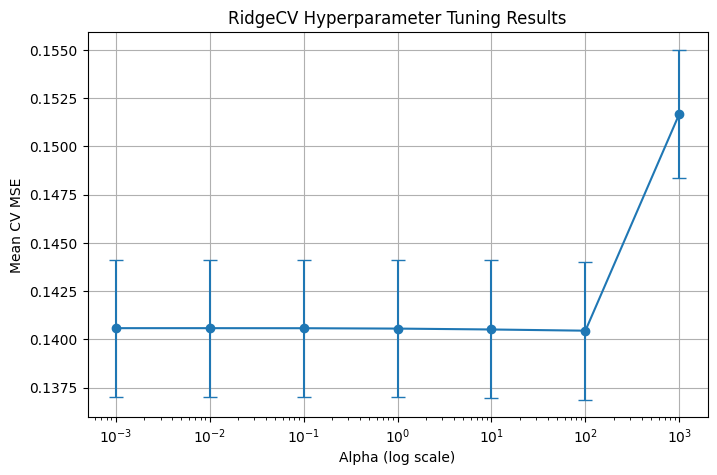

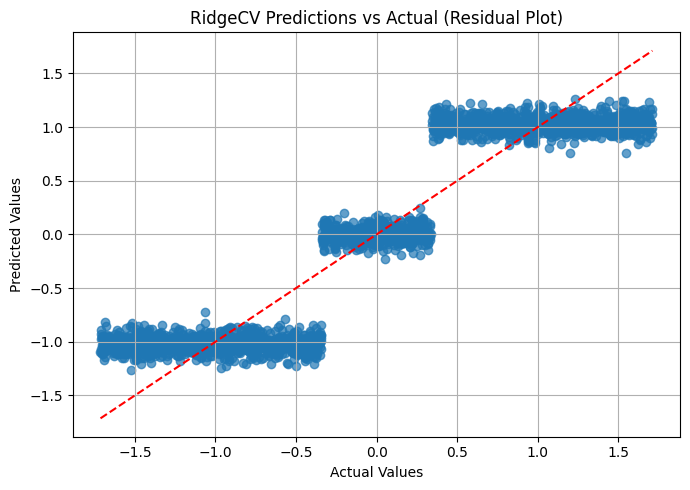

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import RidgeCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import cross_val_score

# Define alpha grid
alphas = np.logspace(-3, 3, 7)

#RidgeCV with 5-fold CV

ridge_cv = RidgeCV(alphas=alphas, cv=5, scoring='neg_mean_squared_error')
ridge_cv.fit(X_train, y_train)

# Predict on test set
y_pred_cv = ridge_cv.predict(X_test)

# Evaluate test set metrics
mse = mean_squared_error(y_test, y_pred_cv)
rmse = np.sqrt(mse)  # Backward-compatible
mae = mean_absolute_error(y_test, y_pred_cv)
r2 = r2_score(y_test, y_pred_cv)

print("Best alpha (RidgeCV):", ridge_cv.alpha_)
print("Performance on Test Set:")
print(f"R²   : {r2:.4f}")
print(f"RMSE : {rmse:.4f}")
print(f"MAE  : {mae:.4f}")

# Manual cross-validation for each alpha
cv_results = []
for alpha in alphas:
    ridge = RidgeCV(alphas=[alpha], cv=5, scoring='neg_mean_squared_error')
    scores = cross_val_score(ridge, X_train, y_train, cv=5, scoring='neg_mean_squared_error')
    cv_results.append([alpha, -scores.mean(), scores.std()])  # convert to positive MSE

results_df = pd.DataFrame(cv_results, columns=["alpha", "CV_MSE", "CV_STD"])
print("\nCross-validation results per alpha:")
print(results_df)

# Visualization: CV MSE vs alpha
plt.figure(figsize=(8,5))
plt.errorbar(results_df["alpha"], results_df["CV_MSE"], yerr=results_df["CV_STD"], fmt='-o', capsize=5)
plt.xscale("log")
plt.xlabel("Alpha (log scale)")
plt.ylabel("Mean CV MSE")
plt.title("RidgeCV Hyperparameter Tuning Results")
plt.grid(True)
plt.show()

# Optional: Residual plot
plt.figure(figsize=(7,5))
plt.scatter(y_test, y_pred_cv, alpha=0.7)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.title("RidgeCV Predictions vs Actual (Residual Plot)")
plt.grid(True)
plt.tight_layout()
plt.show()


The Ridge Regression model with alpha = 100 achieves excellent predictive performance with low error and high explained variance. The CV results confirm that the chosen alpha effectively regularizes the model, preventing overfitting while maintaining accuracy. Overall, the residuals and predicted values align well with the actual values, demonstrating that the model captures the underlying data patterns reliably.

In [ ]:
# Cell baru di akhir notebook Final_Project.ipynb
import joblib
import pickle
import datetime
import pandas as pd
import numpy as np
import kagglehub
from kagglehub import KaggleDatasetAdapter
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
from scipy.sparse import hstack
import re

# Reload the dataset to access original text columns
file_path = "Social Media Engagement Dataset.csv"
df_original = kagglehub.load_dataset(
  KaggleDatasetAdapter.PANDAS,
  "subashmaster0411/social-media-engagement-dataset",
  file_path,
)

# Re-apply text preprocessing
def word_preproccessing(df, col):
    regex_pattern = r'[^\w\s]|[\d]'
    stop_words = set(stopwords.words('english'))
    lemmatizer = WordNetLemmatizer()
    ps = PorterStemmer()

    for c in col:
        df[c] = df[c].astype(str).apply(lambda x: x.lower())
        if c != 'mentions':
            df[c] = df[c].apply(lambda x: re.sub(r'@\w+', '', x))
        if c != 'hashtags':
            df[c] = df[c].apply(lambda x: re.sub(r'#\w+', '', x))
            df[c] = df[c].apply(lambda x: re.sub(regex_pattern, ' ', x))
        else:
             df[c] = df[c].apply(lambda x: re.sub(r'#', '', x))

        df[c] = df[c].apply(lambda x: re.sub(r'\s+', ' ', x).strip())
        df[c] = df[c].apply(lambda x: ' '.join([word for word in word_tokenize(x) if word not in (stop_words)]))
        df[c] = df[c].apply(lambda x: ' '.join([lemmatizer.lemmatize(word, 'v') for word in x.split()]))
        df[c] = df[c].apply(lambda x: ' '.join([ps.stem(word) for word in x.split()]))
    return df

word_columns = ['text_content', 'mentions', 'hashtags']
df_processed_text = word_preproccessing(df_original.copy(), word_columns)


# Fit TF-IDF vectorizers on the processed text data
tfidf_text_vectorizer = TfidfVectorizer(max_features=3000).fit(df_processed_text["text_content"])
tfidf_mentions_vectorizer = TfidfVectorizer(max_features=1000).fit(df_processed_text["mentions"])
tfidf_hashtags_vectorizer = TfidfVectorizer(max_features=1000).fit(df_processed_text["hashtags"])

# Simpan semua komponen model yang diperlukan
model_components = {
    'ridge_model': ridge_cv,  # Model Ridge yang sudah dilatih
    'scaler': scaler,   # StandardScaler yang sudah di-fit
    'tfidf_text_vectorizer': tfidf_text_vectorizer,
    'tfidf_mentions_vectorizer': tfidf_mentions_vectorizer,
    'tfidf_hashtags_vectorizer': tfidf_hashtags_vectorizer,
    'ordinal_encoder': oe,  # OrdinalEncoder yang sudah di-fit
    'label_encoders': encoders,  # Dictionary label encoders
    'feature_columns': list(dfc.columns),  # Nama kolom fitur (termasuk target untuk scaler)
    'target_column': 'sentiment_score', # Name of the target column
    'model_performance': { # Model performance metrics
        'best_alpha': ridge_cv.alpha_,
        'r2_score': r2,
        'rmse': rmse,
        'mae': mae
    },
    'model_type': 'Ridge Regression', # Model type
    'creation_date': datetime.datetime.now().strftime("%Y-%m-%d %H:%M:%S"), # Date and time of creation
    'dataset_info': { # Information about the dataset used
        'total_samples': df.shape[0],
        'features_count': X_train.shape[1],
        'training_samples': X_train.shape[0],
        'test_samples': X_test.shape[0]
    }
}

# Simpan ke file
joblib.dump(model_components, 'sentiment_model_ridge.joblib')
print("✅ Model berhasil disimpan ke 'sentiment_model_ridge.joblib'")

# Verifikasi file tersimpan
import os
if os.path.exists('sentiment_model_ridge.joblib'):
    file_size = os.path.getsize('sentiment_model_ridge.joblib') / (1024*1024)  # MB
    print(f"📁 File size: {file_size:.2f} MB")
else:
    print("❌ File tidak ditemukan!")

In [ ]:
import joblib
import pandas as pd
import numpy as np
import re
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
from scipy.sparse import hstack

# Load the saved model components
try:
    model_components = joblib.load('sentiment_model_ridge.joblib')

    ridge_model = model_components['ridge_model']
    scaler = model_components['scaler']
    tfidf_text_vectorizer = model_components['tfidf_text_vectorizer']
    tfidf_mentions_vectorizer = model_components['tfidf_mentions_vectorizer']
    tfidf_hashtags_vectorizer = model_components['tfidf_hashtags_vectorizer']
    ordinal_encoder = model_components['ordinal_encoder']
    label_encoders = model_components['label_encoders'] # Dictionary of label encoders
    feature_columns = model_components['feature_columns'] # Feature columns used during training (includes target for scaler)
    target_column = model_components['target_column'] # Name of the target column


    print("✅ Model components loaded successfully.")

except FileNotFoundError:
    print("❌ Error: 'sentiment_model_ridge.joblib' not found. Please make sure the model was saved correctly.")
except KeyError as e:
    print(f"❌ Error loading model components: Missing key {e}. The saved file might be corrupted or incomplete.")


# Function to preprocess new data for prediction
def preprocess_new_data_for_prediction(new_data_df, tfidf_text, tfidf_mentions, tfidf_hashtags, ordinal_encoder, label_encoders, feature_columns, target_column):
    df_processed = new_data_df.copy()

    # Handle potential missing 'mentions' column if it's not in new data
    if 'mentions' not in df_processed.columns:
        df_processed['mentions'] = 'None'
    # Handle potential missing 'hashtags' column if it's not in new data
    if 'hashtags' not in df_processed.columns:
        df_processed['hashtags'] = '' # or a suitable default


    # Apply the same text preprocessing function used during training
    def word_preproccessing_inference(df, col):
        regex_pattern = r'[^\w\s]|[\d]'
        stop_words = set(stopwords.words('english'))
        lemmatizer = WordNetLemmatizer()
        ps = PorterStemmer()

        for c in col:
            df[c] = df[c].astype(str).apply(lambda x: x.lower())
            if c != 'mentions':
                df[c] = df[c].apply(lambda x: re.sub(r'@\w+', '', x))
            if c != 'hashtags':
                df[c] = df[c].apply(lambda x: re.sub(r'#\w+', '', x))
                df[c] = df[c].apply(lambda x: re.sub(regex_pattern, ' ', x))
            else:
                 df[c] = df[c].apply(lambda x: re.sub(r'#', '', x))

            df[c] = df[c].apply(lambda x: re.sub(r'\s+', ' ', x).strip())
            df[c] = df[c].apply(lambda x: ' '.join([word for word in word_tokenize(x) if word not in (stop_words)]))
            df[c] = df[c].apply(lambda x: ' '.join([lemmatizer.lemmatize(word, 'v') for word in x.split()]))
            df[c] = df[c].apply(lambda x: ' '.join([ps.stem(word) for word in x.split()]))
        return df

    word_columns_inference = ['text_content', 'mentions', 'hashtags']
    df_processed = word_preproccessing_inference(df_processed, word_columns_inference)


    # Apply TF-IDF transformation
    tfidf_text_transformed = tfidf_text.transform(df_processed["text_content"])
    tfidf_mentions_transformed = tfidf_mentions.transform(df_processed["mentions"])
    tfidf_hashtags_transformed = tfidf_hashtags.transform(df_processed["hashtags"])

    X_tfidf_transformed = hstack([tfidf_text_transformed, tfidf_mentions_transformed, tfidf_hashtags_transformed])

    # Create DataFrame from TF-IDF results
    tfidf_feature_names = (
        [f"text_{w}" for w in tfidf_text.get_feature_names_out()] +
        [f"mentions_{w}" for w in tfidf_mentions.get_feature_names_out()] +
        [f"hashtag_{w}" for w in tfidf_hashtags.get_feature_names_out()]
    )
    df_tfidf_transformed = pd.DataFrame.sparse.from_spmatrix(X_tfidf_transformed, columns=tfidf_feature_names)


    # Apply ordinal encoding
    ordinal_columns = ['day_of_week', 'sentiment_label', 'emotion_type', 'campaign_phase']
    df_processed[ordinal_columns] = ordinal_encoder.transform(df_processed[ordinal_columns]).astype(int)


    # Apply label encoding (if any binary object columns exist)
    for col, encoder in label_encoders.items():
        df_processed[col] = encoder.transform(df_processed[col])


    # Apply one-hot encoding
    ohe_columns_inference = [col for col in df_processed.columns if df_processed[col].dtype == 'object'] # Identify object columns remaining
    df_processed_ohe = pd.get_dummies(df_processed, columns=ohe_columns_inference)

    # Merge TF-IDF features and other processed features
    # Use concat to handle potential missing columns in either dataframe
    df_processed_final = pd.concat([df_processed_ohe, df_tfidf_transformed], axis=1)


    # Align columns with training data (including target for scaling) - crucial step
    # Add missing columns in the new data with 0
    for col in feature_columns:
        if col not in df_processed_final.columns:
            df_processed_final[col] = 0

    # Drop extra columns in the new data that were not in training data
    extra_cols = [col for col in df_processed_final.columns if col not in feature_columns]
    df_processed_final = df_processed_final.drop(columns=extra_cols)

    # Ensure the order of columns is the same as training data
    df_processed_final = df_processed_final[feature_columns]


    return df_processed_final


# Create a sample new data point (replace with your actual new data)
sample_new_data = {
    'post_id': ['new_post_1'],
    'timestamp': ['2025-01-01 12:00:00'], # Placeholder - you'll need to process timestamp correctly
    'day_of_week': ['Wednesday'],
    'platform': ['Instagram'],
    'user_id': ['new_user_1'],
    'location': ['New York, USA'],
    'language': ['en'],
    'text_content': ['This is a great product! I love it.'],
    'hashtags': ['#GreatProduct #Happy'],
    'mentions': ['@BrandName'],
    'keywords': ['great, love'], # Placeholder - keywords were not used in the model
    'topic_category': ['Product'],
    'sentiment_score': [0.0], # Placeholder - this is what we will predict
    'sentiment_label': ['Neutral'], # Placeholder - will be encoded
    'emotion_type': ['Happy'], # Placeholder - will be encoded
    'toxicity_score': [0.1],
    'likes_count': [100],
    'shares_count': [10],
    'comments_count': [5],
    'impressions': [1000],
    'engagement_rate': [0.1],
    'brand_name': ['NewBrand'],
    'product_name': ['NewProduct'],
    'campaign_name': ['NewCampaign'],
    'campaign_phase': ['Launch'], # Placeholder - will be encoded
    'user_past_sentiment_avg': [0.5],
    'user_engagement_growth': [0.1],
    'buzz_change_rate': [5.0]
}

sample_df = pd.DataFrame(sample_new_data)

# Preprocess the sample new data
# Convert Timestamp to day, hour, month and year
sample_df["timestamp"] = pd.to_datetime(sample_df["timestamp"])
sample_df["year"] = sample_df["timestamp"].dt.year
sample_df["month"] = sample_df["timestamp"].dt.month
sample_df["day"] = sample_df["timestamp"].dt.day
sample_df["hour"] = sample_df["timestamp"].dt.hour
sample_df = sample_df.drop(columns=["timestamp", "post_id", "user_id", "keywords"], axis=1) # Drop columns not used in training


processed_sample_data = preprocess_new_data_for_prediction(sample_df, tfidf_text_vectorizer, tfidf_mentions_vectorizer, tfidf_hashtags_vectorizer, ordinal_encoder, label_encoders, feature_columns, target_column)


# Scale the processed data
scaled_sample_data = scaler.transform(processed_sample_data)

# Find the index of the target column
target_column_index = feature_columns.index(target_column)

# Drop the target column from the scaled NumPy array
scaled_sample_data = np.delete(scaled_sample_data, target_column_index, axis=1)


# Make prediction using the loaded model
predicted_sentiment_score = ridge_model.predict(scaled_sample_data)

print(f"\nPredicted Sentiment Score: {predicted_sentiment_score[0]}")